In [1]:
import os
import re
import json
import torch
import argparse
from openai import OpenAI
import base64
from web_search import web_search_SERPER_API, web_search_DDG
from tqdm import tqdm
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# 定义颜色的ANSI代码
RED = '\033[91m'
GREEN = '\033[92m'
YELLOW = '\033[93m'
RESET = '\033[0m'  # 重置颜色

def plot_images(image_paths):
    num_images = len(image_paths)
    
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
    
    for i, image_path in enumerate(image_paths):
        img = mpimg.imread(image_path)

        # 如果是灰度图（2D），扩展为 RGB
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        # 如果是带 alpha 通道的 RGBA 图，去掉 alpha
        elif img.shape[2] == 4:
            img = img[:, :, :3]

        ax = axes if num_images == 1 else axes[i]
        ax.imshow(img)
        ax.set_title(f'Image {i+1}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


/fs-computility/mllm/liuziyu/miniconda3/envs/r1-v/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = '/share_models/Qwen2.5-VL-7B-Instruct_GRPO_agent_search_data20_63_gpu8/checkpoint-200/'

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map='cuda:0',
)
processor = AutoProcessor.from_pretrained(model_path)

Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
system_prompt = """# Role  
You are a step-by-step multimodal reasoning assistant.  
Given an image, a question, and optional partial reasoning chain, your task is to solve the problem **one substep at a time**.  

# Guiding Principles  
At each turn, you must **either**:  
1. Issue **one specific, text-only search** enclosed in <search> </search> tags,  
2. Or provide the **final answer** enclosed in <answer> </answer> tags.  

All outputs **must begin with a thought** enclosed in <think> </think> tags, explaining your current reasoning and what to do next.  

- Do not reference “the image” in your searches.  
- Do not repeat past queries.  
- Only output **one action per step**: either <search> or <answer>, never both.  
- When ready to conclude, summarize reasoning and give a final answer.

# Output Format (strict):  
Always start with <think>. Do not output the previous reasoning chain. Then, depending on the case, output one of the following:

## 1. If reasoning continues:  
<think> Your current reasoning and next plan </think>  
<search> One precise, retrievable textual query </search>

## 2. If ready to conclude:  
<think> Summarize all reasoning and derive the answer </think>  
<answer> Final answer, as briefly as possible </answer>

# Current reasoning chain:
"""

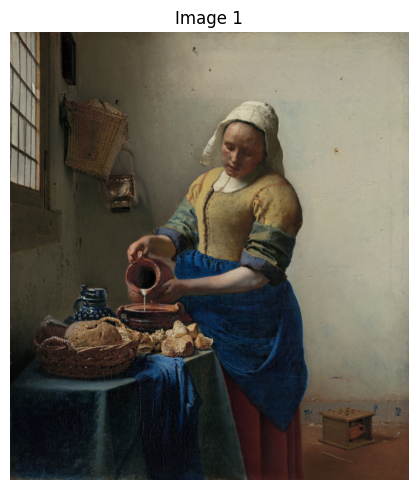

Is this painting housed in the same location as The Night Watch?
<think> To determine if "The Milkmaid" is housed in the same location as "The Night Watch," I need to identify the museums where these paintings are currently displayed. </think>
<search> Museum where The Milkmaid is housed </search>
[{'title': "Can You Find Vermeer's Milkmaid at the Rijksmusem?", 'href': 'https://artsandculture.google.com/story/can-you-find-vermeer-39-s-milkmaid-at-the-rijksmusem/mgWRovPAVXY1sQ?hl=en', 'body': "Today we're at the Rijksmuseum in Amsterdam. Opened in 1885, this museum of art and history is located at the Museum Square, close to the Van Gogh Museum ..."}, {'title': 'The Milkmaid (Vermeer) - Wikipedia', 'href': 'https://en.wikipedia.org/wiki/The_Milkmaid_(Vermeer)', 'body': 'It is in the Rijksmuseum in Amsterdam, the Netherlands, which regards it as "unquestionably one of the museum\'s finest attractions". The Milkmaid. Artist ...'}, {'title': "Rijksmuseum reveals major discoveries on Vermee

In [4]:
query = 'Is this painting housed in the same location as The Night Watch?'
input_image_path = './pics/23.jpg'
input_text = system_prompt + '\n' +f'<query> {query} <query>'
plot_images([input_image_path])
print(RED+query+RESET)

try:
    iterative_num = 0
    while iterative_num<5: # iteration > 5 , skip
        iterative_num += 1
        ###### inference ######
        messages = [
            { "role": "user", "content": [{"type": "image","image": input_image_path}, {"type": "text", "text": input_text}]}
        ]
        # Preparation for inference
        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to(model.device)

        # Inference: Generation of the output
        generated_ids = model.generate(**inputs, max_new_tokens=2048)
        generated_ids_trimmed = [
            out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        output_text = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )
        result = output_text[0]
        print(YELLOW+result+RESET)

        ###### Actioin judge: search or answer ######
        if '<answer>' in result:
            match = re.search(r"<answer>\s*(.*?)\s*</answer>", result)
            if match:
                pred_answer = match.group(1).strip()
            else:
                pred_answer = None
            print(GREEN+pred_answer+RESET)
            break
        elif '<search>' in result:
            match = re.search(r"<search>\s*(.*?)\s*</search>", result)
            if match:
                search_content = match.group(1).strip()

            # serper API web search: body   search_number: default to 4
            search_results = web_search_SERPER_API(search_content, 4)
            print(search_results)
            format_search_results = '<information> '
            for index,item in enumerate(search_results):
                format_search_results += f'{index+1}.' + ' '+"Content:"+item['body']
            format_search_results += ' </information> '
        
            # Updata in-context
            input_text = input_text +'\n'+ result +'\n'+ format_search_results
except Exception as e:
    print("ERROR OCCURES")
    print({e})

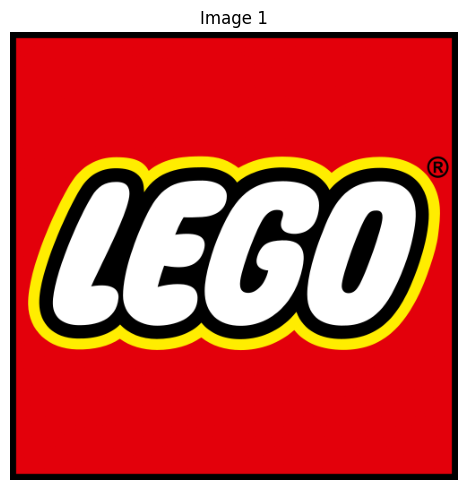

What is the original meaning of the brand name in the language of the country the brand is located?
<think> The image provided is the logo for LEGO, which is a well-known toy company. To determine the original meaning of the brand name in the language of the country where it is located, I need to identify the country associated with LEGO and then translate the word "LEGO" into that language. </think>
<search> Country where LEGO is headquartered </search>
[{'title': 'The Lego Group - Wikipedia', 'href': 'https://en.wikipedia.org/wiki/The_Lego_Group', 'body': 'The first Lego store in India was opened in Chennai, Tamil Nadu in ... The company was founded as Lego Media in 1996 and headquartered in London, England.'}, {'title': 'LEGO Group - About Us', 'href': 'https://www.lego.com/en-us/aboutus/lego-group', 'body': 'The LEGO Group is a privately held company based in Billund, Denmark. The company is still owned by the Kirk Kristiansen family who founded it in 1932.'}, {'title': 'Locations 

In [6]:
query = 'What is the original meaning of the brand name in the language of the country the brand is located?'
input_image_path = './pics/annotation2.jpg'
input_text = system_prompt + '\n' +f'<query> {query} <query>'
plot_images([input_image_path])
print(RED+query+RESET)

try:
    iterative_num = 0
    while iterative_num<5: # iteration > 5 , skip
        iterative_num += 1
        ###### inference ######
        messages = [
            { "role": "user", "content": [{"type": "image","image": input_image_path}, {"type": "text", "text": input_text}]}
        ]
        # Preparation for inference
        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to(model.device)

        # Inference: Generation of the output
        generated_ids = model.generate(**inputs, max_new_tokens=2048)
        generated_ids_trimmed = [
            out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        output_text = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )
        result = output_text[0]
        print(YELLOW+result+RESET)

        ###### Actioin judge: search or answer ######
        if '<answer>' in result:
            match = re.search(r"<answer>\s*(.*?)\s*</answer>", result)
            if match:
                pred_answer = match.group(1).strip()
            else:
                pred_answer = None
            print(GREEN+pred_answer+RESET)
            break
        elif '<search>' in result:
            match = re.search(r"<search>\s*(.*?)\s*</search>", result)
            if match:
                search_content = match.group(1).strip()

            # serper API web search: body   search_number: default to 4
            search_results = web_search_SERPER_API(search_content, 4)
            print(search_results)
            format_search_results = '<information> '
            for index,item in enumerate(search_results):
                format_search_results += f'{index+1}.' + ' '+"Content:"+item['body']
            format_search_results += ' </information> '
        
            # Updata in-context
            input_text = input_text +'\n'+ result +'\n'+ format_search_results
except Exception as e:
    print("ERROR OCCURES")
    print({e})